## Import packages

In [576]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import loguniform, uniform
import shap
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000) 
pd.set_option('display.colheader_justify', 'center') 


# Load dataset

In [876]:
data = pd.read_csv('data/Energy_consumption.csv')
data.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


- *Timestamp:* The chronological record of each data point, providing a time-based context.
- *Temperature:* Numerical variable representing the temperature in degrees Celsius.
- *Humidity:* Numerical variable showing the humidity level as a percentage.
- *SquareFootage:* Numerical variable measuring the area of the building or space.
- *Occupancy:* Numerical variable representing the number of people in the area.
- *HVACUsage:* Categorical variable indicating the usage of Heating, Ventilation, and Air Conditioning systems.
- *LightingUsage:* Categorical variable indicating the usage of lighting systems.
- *RenewableEnergy:* Numerical variable representing the percentage contribution of renewable energy sources.
- *DayOfWeek:* Categorical variable indicating the day of the week.
- *Holiday:* Boolean categorical variable indicating whether the day is a holiday.
- *EnergyConsumption:* Numerical target variable representing the total energy consumed.


In [879]:
data.shape

(1000, 11)

## Let's check the missing values ​​again

In [882]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          1000 non-null   object 
 1   Temperature        1000 non-null   float64
 2   Humidity           1000 non-null   float64
 3   SquareFootage      1000 non-null   float64
 4   Occupancy          1000 non-null   int64  
 5   HVACUsage          1000 non-null   object 
 6   LightingUsage      1000 non-null   object 
 7   RenewableEnergy    1000 non-null   float64
 8   DayOfWeek          1000 non-null   object 
 9   Holiday            1000 non-null   object 
 10  EnergyConsumption  1000 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 86.1+ KB


In [884]:
data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Temperature,1000.0,24.98,2.84,20.01,22.65,24.75,27.42,30.00
Humidity,1000.0,45.40,8.52,30.02,38.30,45.97,52.42,59.97
SquareFootage,1000.0,1500.05,288.42,1000.51,1247.11,1507.97,1740.34,1999.98
Occupancy,1000.0,4.58,2.87,0.00,2.00,5.00,7.00,9.00
RenewableEnergy,1000.0,15.13,8.75,0.01,7.63,15.07,22.88,29.97
EnergyConsumption,1000.0,77.06,8.14,53.26,71.54,76.94,82.92,99.20


The dataset contains several columns that are completely null and others with null values, so we'll skip all columns containing zeros and NaNs, as they're unusable. Let's check them and remove them.

### Missing

In [888]:
missing = pd.concat([data.isnull().sum(), 100 * data.isnull().mean()], axis=1)
missing.columns=['Count', 'Percent_%']
missing.sort_values(by=['Count'],ascending = False)
missing

,Count,Percent_%
Timestamp,0,0.0
Temperature,0,0.0
Humidity,0,0.0
SquareFootage,0,0.0
Occupancy,0,0.0
HVACUsage,0,0.0
LightingUsage,0,0.0
RenewableEnergy,0,0.0
DayOfWeek,0,0.0
Holiday,0,0.0


### Duplicates

In [891]:
duplicates = data[data.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [Timestamp, Temperature, Humidity, SquareFootage, Occupancy, HVACUsage, LightingUsage, RenewableEnergy, DayOfWeek, Holiday, EnergyConsumption]
Index: []


### Convert 'Timestamp' to datetime

In [894]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['Day'] = data['Timestamp'].dt.day
data['Month'] = data['Timestamp'].dt.month
data = data.drop(columns=['Timestamp'])

In [896]:
data.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month
0,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373,0,1,1
1,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855,1,1,1
2,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888,2,1,1
3,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850,3,1,1
4,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732,4,1,1


# EDA

## Data Visualization

In [900]:
num_cols = data.select_dtypes(exclude = ['object']).columns
cat_cols = data.select_dtypes(include= ['object']).columns
print("Numerical features:", num_cols)
print("Categorical features:", cat_cols)

Numerical features: Index(['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption', 'Hour', 'Day', 'Month'], dtype='object')
Categorical features: Index(['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday'], dtype='object')


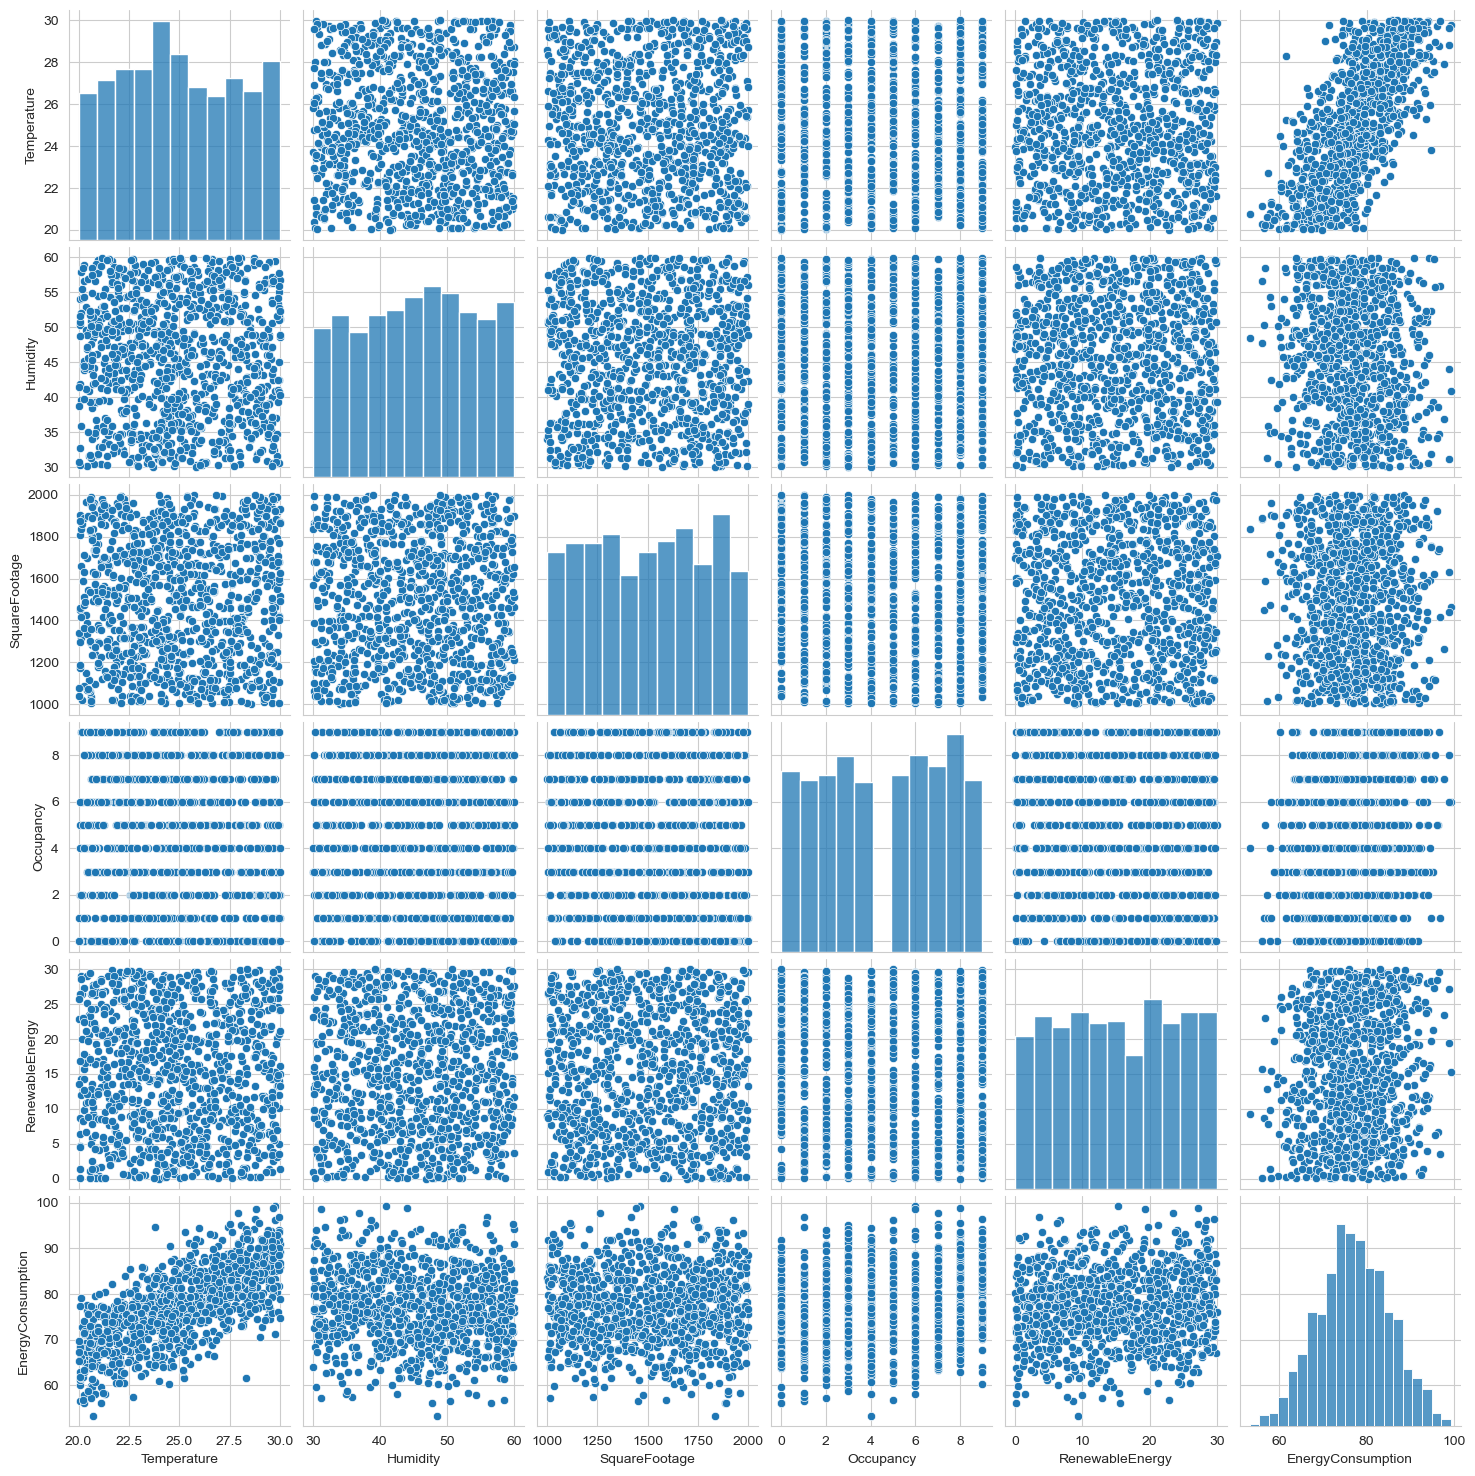

In [902]:
sns.pairplot(data[['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption']])
plt.show()

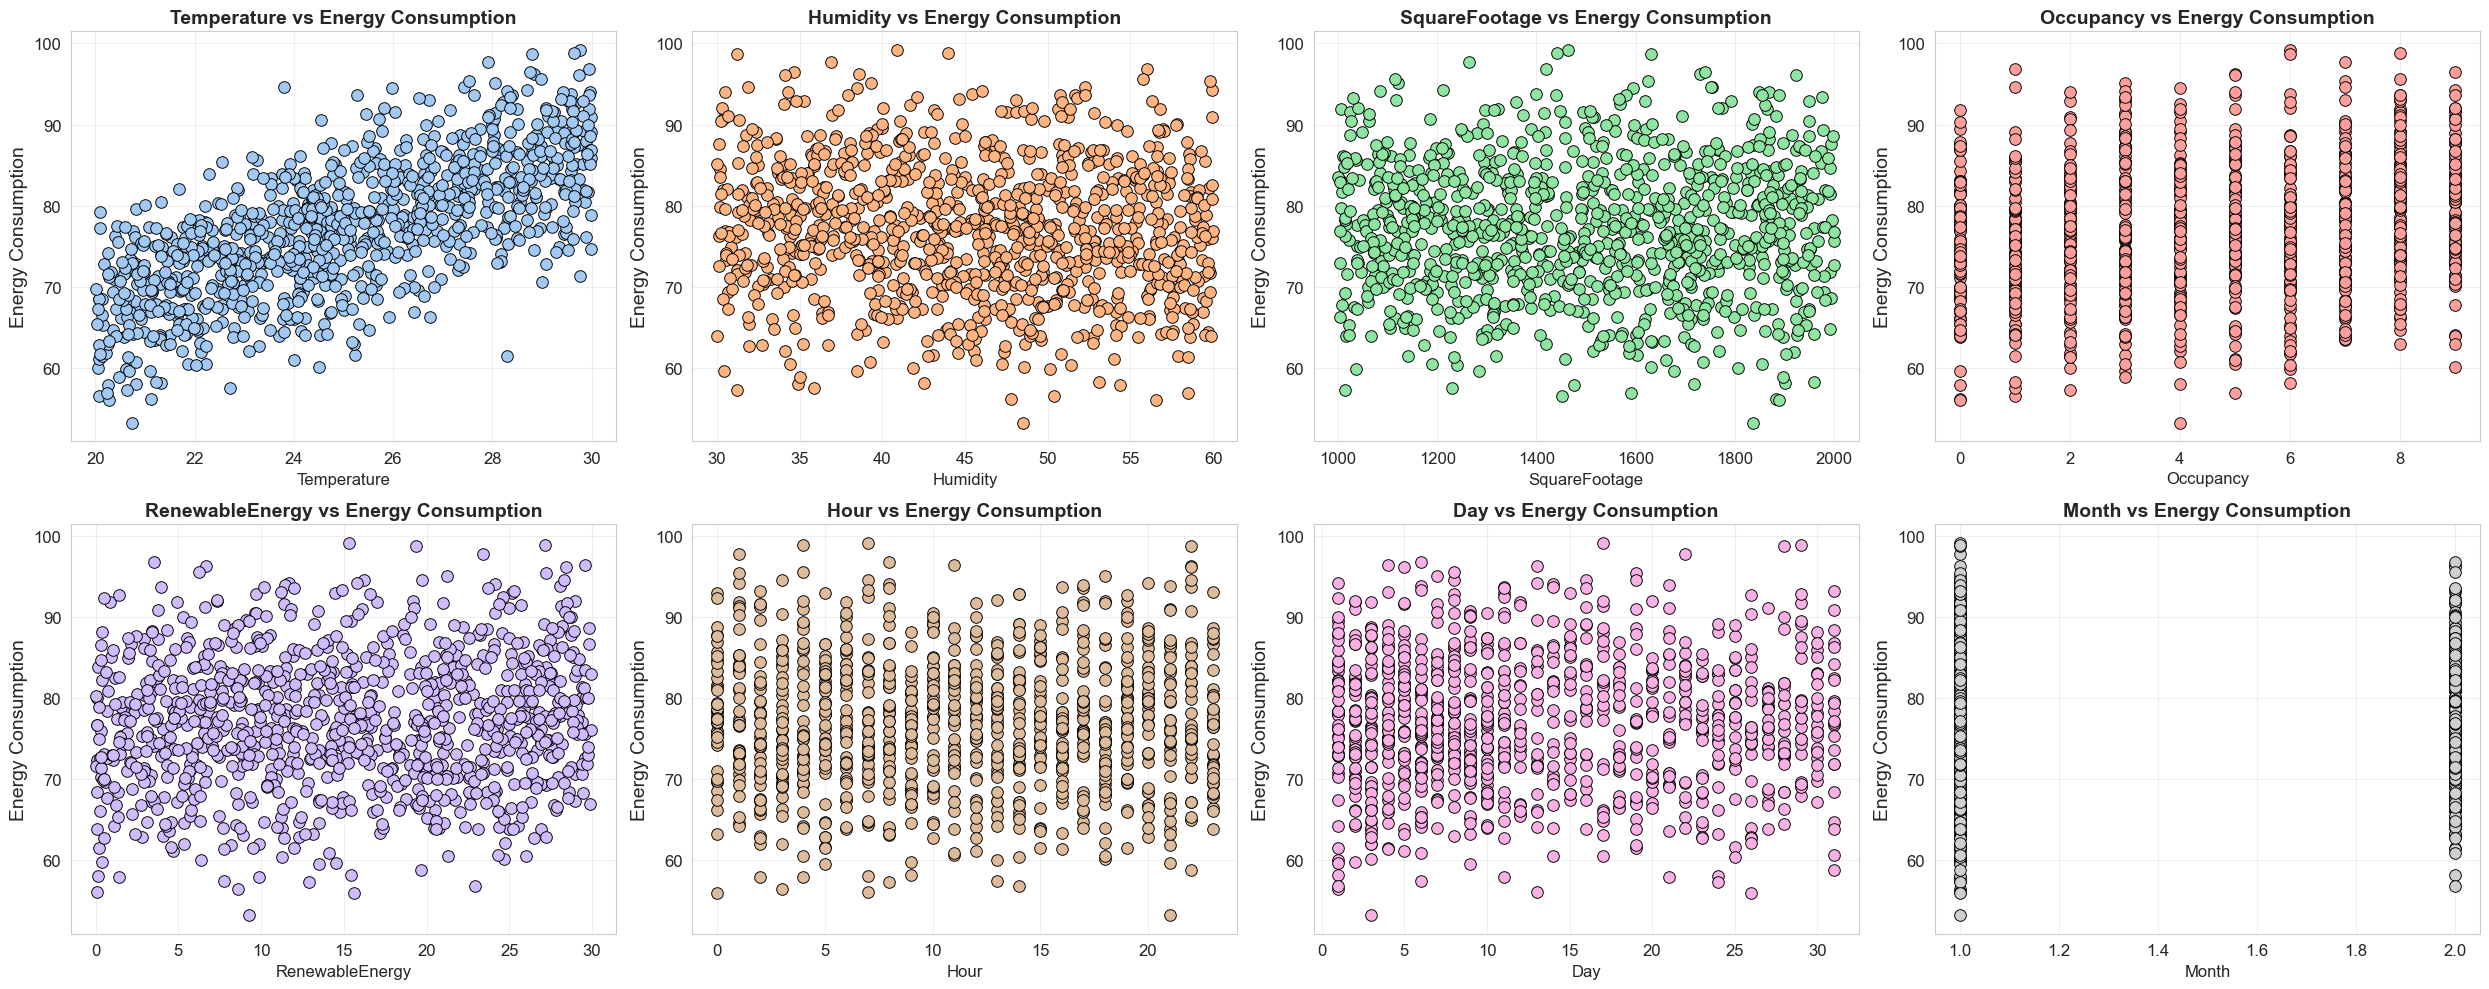

In [903]:
features = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'Hour', 'Day', 'Month']

fig, ax = plt.subplots(2, 4, figsize=(25, 10))
sns.set_style("whitegrid")
ax = ax.flatten() 

colors = sns.color_palette("pastel", len(features))

for i, feature in enumerate(features):
    sns.scatterplot(
        ax=ax[i],
        x=feature,
        y='EnergyConsumption',
        data=data,
        color=colors[i],
        edgecolor="black",
        s=70
    )
    ax[i].set_title(f'{feature} vs Energy Consumption', fontsize=14, fontweight='bold')
    ax[i].set_xlabel(feature, fontsize=12)
    ax[i].set_ylabel('Energy Consumption', fontsize=14)
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].grid(alpha=0.3)

for j in range(len(features), len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

##  Outliers

To detect outliers in your data, you can use several simple methods:

- Boxplot: The boxplot displays outliers as points outside the box.

- Z-score: A value is considered an outlier if its z-score > 3 (or < -3)
(used to indicate how many standard deviations a data point lies from the mean of a data set).

- Interquartile range (IQR): A value is considered an outlier if it falls outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR].

### Categorical features

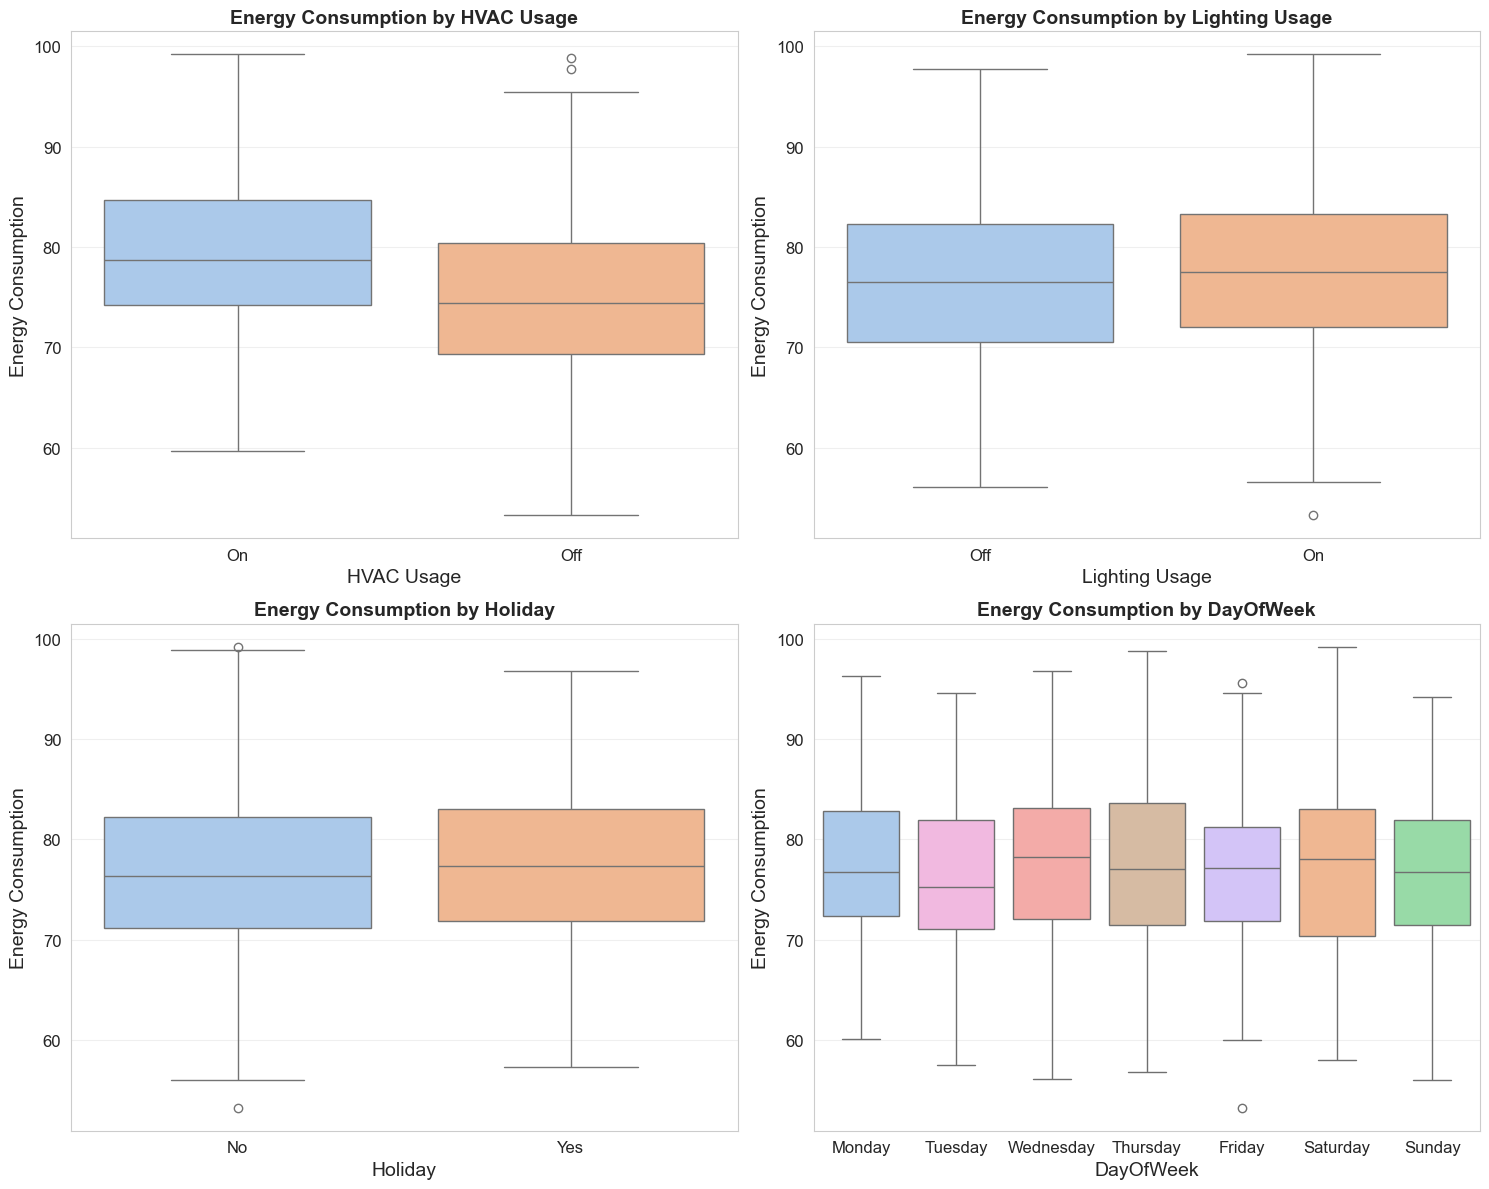

In [907]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(2, 2, figsize=(15, 12))

# Boxplot: HVAC Usage vs Energy Consumption
sns.boxplot(ax=ax[0,0], x='HVACUsage', y='EnergyConsumption', hue='HVACUsage', data=data, palette="pastel", legend=False)
ax[0,0].set_title('Energy Consumption by HVAC Usage', fontsize=14, fontweight='bold')
ax[0,0].set_xlabel('HVAC Usage', fontsize=14)
ax[0,0].set_ylabel('Energy Consumption', fontsize=14)
ax[0,0].tick_params(axis='x', labelsize=12)
ax[0,0].tick_params(axis='y', labelsize=12)
ax[0,0].grid(axis='y', alpha=0.3)

# Boxplot: Lighting Usage vs Energy Consumption
sns.boxplot(ax=ax[0,1], x='LightingUsage', y='EnergyConsumption', hue='LightingUsage', data=data, palette="pastel", legend=False)
ax[0,1].set_title('Energy Consumption by Lighting Usage', fontsize=14, fontweight='bold')
ax[0,1].set_xlabel('Lighting Usage', fontsize=14)
ax[0,1].set_ylabel('Energy Consumption', fontsize=14)
ax[0,1].tick_params(axis='x', labelsize=12)
ax[0,1].tick_params(axis='y', labelsize=12)
ax[0,1].grid(axis='y', alpha=0.3)

# Boxplot: Holiday vs Energy Consumption
sns.boxplot(ax=ax[1,0], x='Holiday', y='EnergyConsumption', hue='Holiday', data=data, palette="pastel", legend=False)
ax[1,0].set_title('Energy Consumption by Holiday', fontsize=14, fontweight='bold')
ax[1,0].set_xlabel('Holiday', fontsize=14)
ax[1,0].set_ylabel('Energy Consumption', fontsize=14)
ax[1,0].tick_params(axis='x', labelsize=12)
ax[1,0].tick_params(axis='y', labelsize=12)
ax[1,0].grid(axis='y', alpha=0.3)

# Boxplot: DayOfWeek vs Energy Consumption
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(ax=ax[1,1], x='DayOfWeek', y='EnergyConsumption', hue='DayOfWeek', data=data, palette="pastel", legend=False, order=days_order)
ax[1,1].set_title('Energy Consumption by DayOfWeek', fontsize=14, fontweight='bold')
ax[1,1].set_xlabel('DayOfWeek', fontsize=14)
ax[1,1].set_ylabel('Energy Consumption', fontsize=14)
ax[1,1].tick_params(axis='x', labelsize=12)
ax[1,1].tick_params(axis='y', labelsize=12)
ax[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

To remove outliers in each categorical group from your variable EnergyConsumption, you should apply the IQR (interquartile range) method within each group.

In [909]:
#num_cols = data.select_dtypes(exclude = ['object']).columns
#cat_cols = data.select_dtypes(include= ['object']).columns
print("Numerical features:", num_cols)
print("Categorical features:", cat_cols)

Numerical features: Index(['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption', 'Hour', 'Day', 'Month'], dtype='object')
Categorical features: Index(['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday'], dtype='object')


In [910]:
def group_outlier_summary(df, group_col, target_col):
    summary = {}
    for group_name, group in df.groupby(group_col):
        Q1 = group[target_col].quantile(0.25)
        Q3 = group[target_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        is_outlier = (group[target_col] < lower) | (group[target_col] > upper)
        outlier_count = is_outlier.sum()
        outlier_percent = round(outlier_count / len(group) * 100, 2) if len(group) > 0 else 0
        summary[group_name] = {
            'outlier_count': outlier_count,
            'outlier_percent': outlier_percent}
    summary_df = pd.DataFrame.from_dict(summary, orient='index')
    summary_df.index.name = group_col
    return summary_df

for col in cat_cols:
    print(f"\nOutlier summary for {col}:")
    display(group_outlier_summary(data, col, 'EnergyConsumption'))


Outlier summary for HVACUsage:


,outlier_count,outlier_percent
HVACUsage,,
Off,2,0.39
On,0,0.00



Outlier summary for LightingUsage:


,outlier_count,outlier_percent
LightingUsage,,
Off,0,0.0
On,1,0.2



Outlier summary for DayOfWeek:


,outlier_count,outlier_percent
DayOfWeek,,
Friday,2,1.22
Monday,0,0.00
Saturday,0,0.00
Sunday,0,0.00
Thursday,0,0.00
Tuesday,0,0.00
Wednesday,0,0.00



Outlier summary for Holiday:


,outlier_count,outlier_percent
Holiday,,
No,2,0.38
Yes,0,0.00


In [911]:
def remove_group_outliers(df, group_col, target_col):
    def iqr_filter(group):
        Q1 = group[target_col].quantile(0.25)
        Q3 = group[target_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return group[(group[target_col] >= lower) & (group[target_col] <= upper)]
    return df.groupby(group_col, group_keys=False).apply(iqr_filter)

def remove_all_group_outliers(df, cat_cols, target_col, max_iter=2):
    prev_len = -1
    curr_df = df.copy()
    i = 0
    while prev_len != len(curr_df) and i < max_iter:
        prev_len = len(curr_df)
        clean_indices = [set(remove_group_outliers(curr_df, col, target_col).index) for col in cat_cols]
        final_indices = set.intersection(*clean_indices)
        curr_df = curr_df.loc[list(final_indices)]
        i += 1
    return curr_df

data_clean = remove_all_group_outliers(data, cat_cols, 'EnergyConsumption')

C:\Users\catas\AppData\Local\Temp\ipykernel_24088\1683809555.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(iqr_filter)
C:\Users\catas\AppData\Local\Temp\ipykernel_24088\1683809555.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(iqr_filter)
C:\Users\catas\AppData\Local\Temp\ipykernel_24088\1683

It's normal for new outliers to appear after cleaning, because the IQR changes. If you want to ensure that no outliers remain in your boxplots for any group, use an iterative method like the one above.

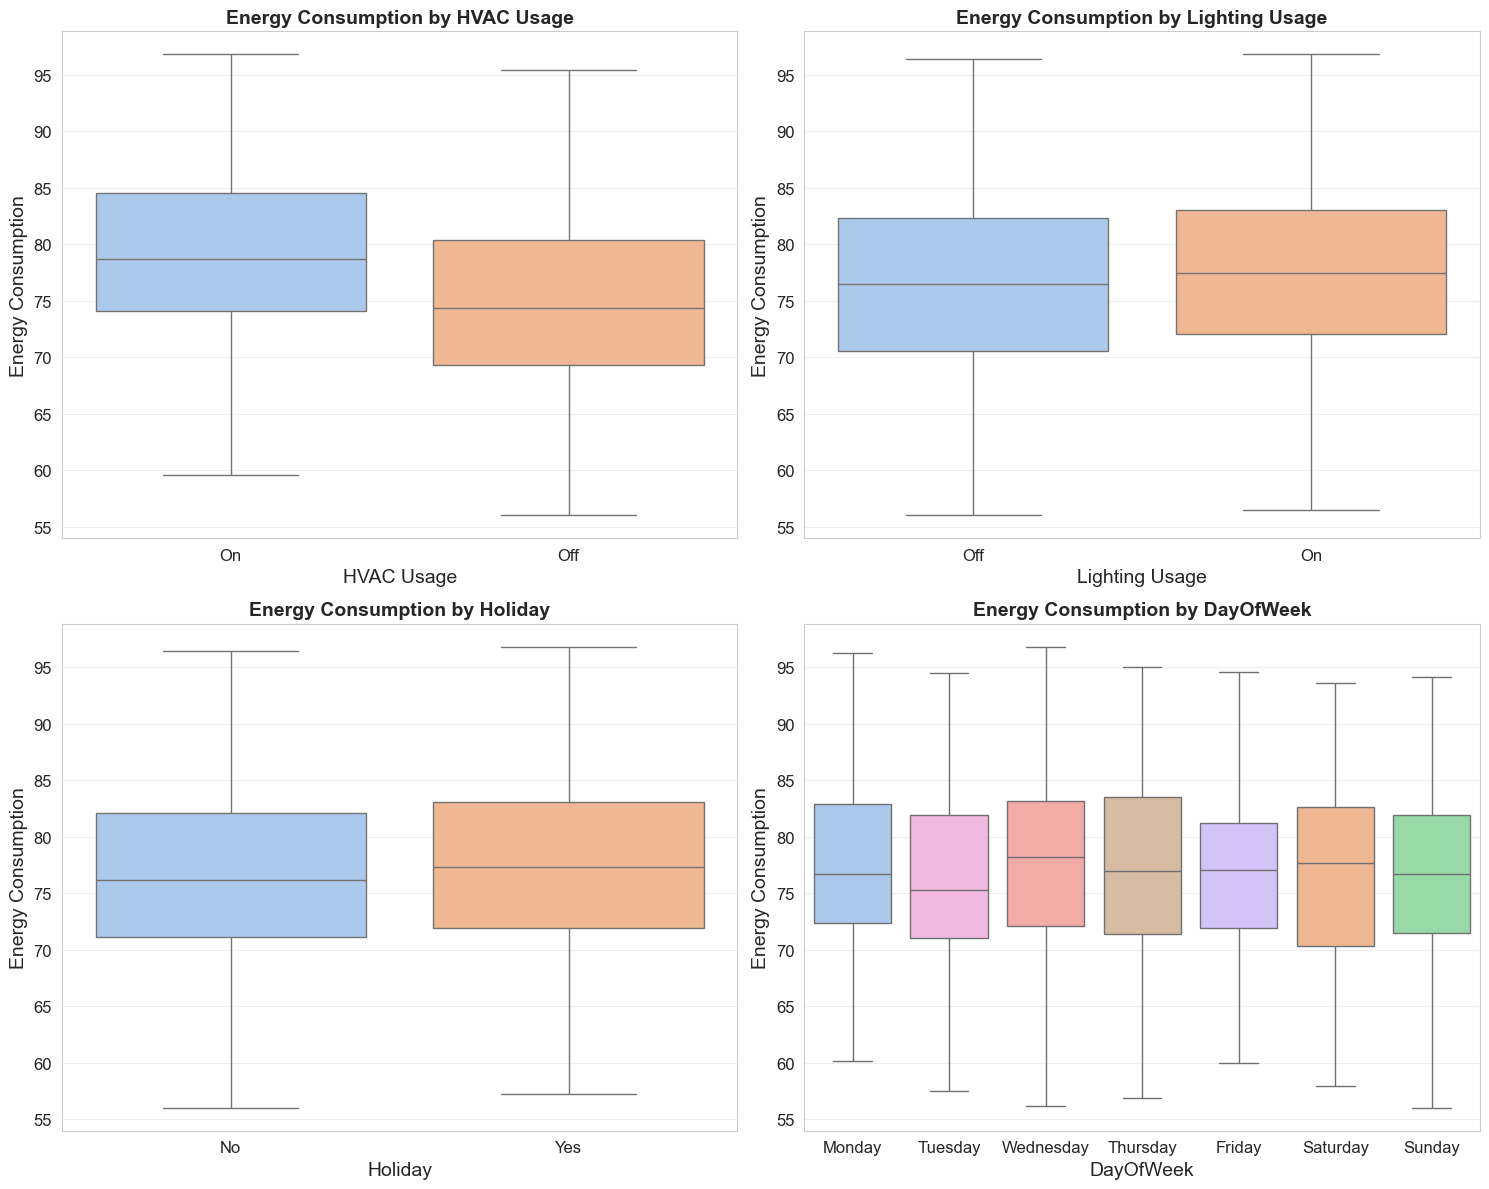

In [913]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(2, 2, figsize=(15, 12))

# Boxplot: HVAC Usage vs Energy Consumption
sns.boxplot(ax=ax[0,0], x='HVACUsage', y='EnergyConsumption', hue='HVACUsage', data=data_clean, palette="pastel", legend=False)
ax[0,0].set_title('Energy Consumption by HVAC Usage', fontsize=14, fontweight='bold')
ax[0,0].set_xlabel('HVAC Usage', fontsize=14)
ax[0,0].set_ylabel('Energy Consumption', fontsize=14)
ax[0,0].tick_params(axis='x', labelsize=12)
ax[0,0].tick_params(axis='y', labelsize=12)
ax[0,0].grid(axis='y', alpha=0.3)

# Boxplot: Lighting Usage vs Energy Consumption
sns.boxplot(ax=ax[0,1], x='LightingUsage', y='EnergyConsumption', hue='LightingUsage', data=data_clean, palette="pastel", legend=False)
ax[0,1].set_title('Energy Consumption by Lighting Usage', fontsize=14, fontweight='bold')
ax[0,1].set_xlabel('Lighting Usage', fontsize=14)
ax[0,1].set_ylabel('Energy Consumption', fontsize=14)
ax[0,1].tick_params(axis='x', labelsize=12)
ax[0,1].tick_params(axis='y', labelsize=12)
ax[0,1].grid(axis='y', alpha=0.3)

# Boxplot: Holiday vs Energy Consumption
sns.boxplot(ax=ax[1,0], x='Holiday', y='EnergyConsumption', hue='Holiday', data=data_clean, palette="pastel", legend=False)
ax[1,0].set_title('Energy Consumption by Holiday', fontsize=14, fontweight='bold')
ax[1,0].set_xlabel('Holiday', fontsize=14)
ax[1,0].set_ylabel('Energy Consumption', fontsize=14)
ax[1,0].tick_params(axis='x', labelsize=12)
ax[1,0].tick_params(axis='y', labelsize=12)
ax[1,0].grid(axis='y', alpha=0.3)

# Boxplot: DayOfWeek vs Energy Consumption
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(ax=ax[1,1], x='DayOfWeek', y='EnergyConsumption', hue='DayOfWeek', data=data_clean, palette="pastel", legend=False, order=days_order)
ax[1,1].set_title('Energy Consumption by DayOfWeek', fontsize=14, fontweight='bold')
ax[1,1].set_xlabel('DayOfWeek', fontsize=14)
ax[1,1].set_ylabel('Energy Consumption', fontsize=14)
ax[1,1].tick_params(axis='x', labelsize=12)
ax[1,1].tick_params(axis='y', labelsize=12)
ax[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

These plots provide an overview of the balance and distribution in key categorical features, useful for identifying potential data biases or ensuring sufficient representation across categories before modeling or deeper analysis.

- *DayOfWeek*:
Displays the distribution of records across the days of the week. The counts for each day (Saturday, Sunday, Monday, Tuesday, Wednesday, Thursday, and Friday) are fairly uniform, indicating that the data is evenly distributed across the week.

- *Holiday*: Shows the count of records for Holiday status ("No" or "Yes"). There are more records for non-holidays ("No") than holidays ("Yes").

- *HVACUsage*:
Illustrates whether HVAC systems were "On" or "Off".The counts for "On" and "Off" are almost equal, suggesting balanced data regarding HVAC usage.

- *LightingUsage*:
Displays whether lighting was "On" or "Off". The counts for both categories are similar, with "Off" slightly higher than "On".

### Numerical features

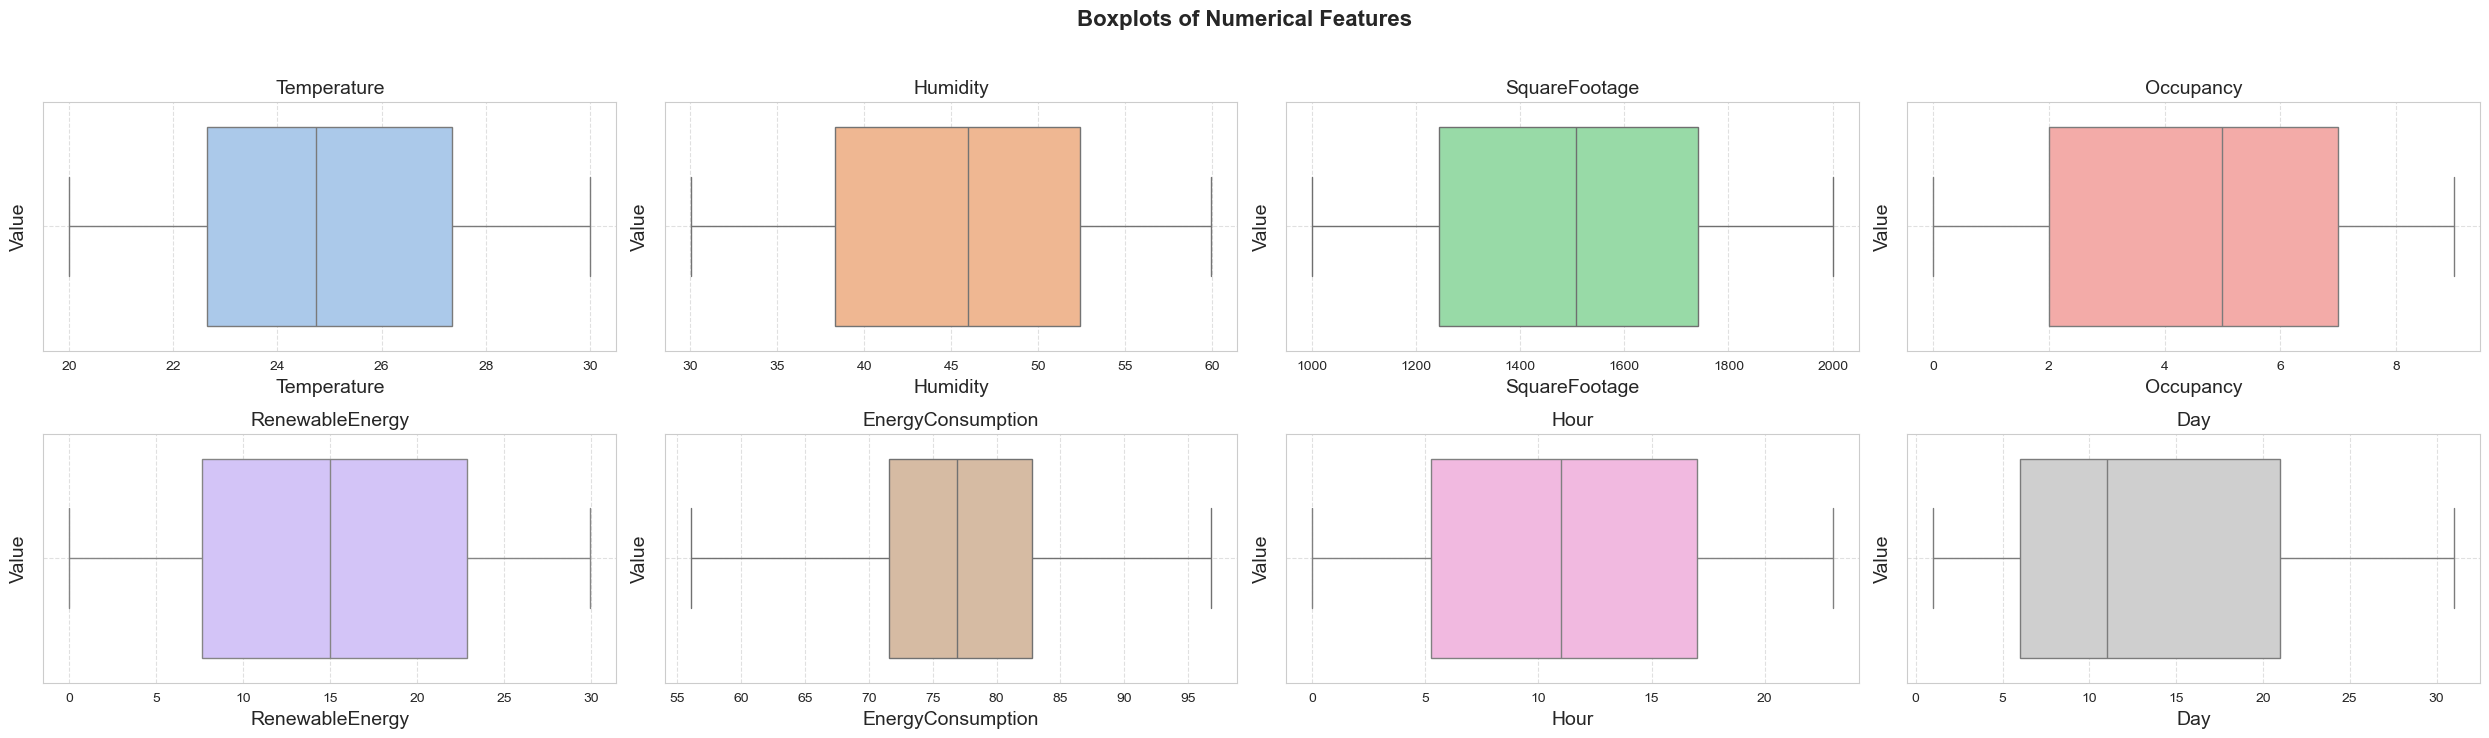

In [917]:
numerical_columns = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption', 'Hour', 'Day']

pastel_colors = sns.color_palette("pastel", len(numerical_columns))

f, ax = plt.subplots(3, 4, figsize=(25, 10), sharey=False)
ax = ax.flatten()

for index, col in enumerate(numerical_columns):
    sns.boxplot(data=data_clean, x=col, ax=ax[index], color=pastel_colors[index])
    ax[index].set_title(col, fontsize=14)
    ax[index].set_xlabel(col, fontsize=14)
    ax[index].set_ylabel("Value", fontsize=14)
    ax[index].grid(True, linestyle="--", alpha=0.6)

for i in range(len(numerical_columns), len(ax)):
    ax[i].set_visible(False)

f.suptitle('Boxplots of Numerical Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [918]:
from scipy.stats import zscore
# Calculate Z-scores for numerical columns
z_scores = data_clean[numerical_columns].apply(zscore)

# Identify outliers (z-score > 3 or z-score < -3)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"Number of outliers detected using Z-scores: {outliers.sum()}")

# Display rows that are considered outliers
outliers_data = data_clean[outliers]
print(outliers_data)

Number of outliers detected using Z-scores: 0
Empty DataFrame
Columns: [Temperature, Humidity, SquareFootage, Occupancy, HVACUsage, LightingUsage, RenewableEnergy, DayOfWeek, Holiday, EnergyConsumption, Hour, Day, Month]
Index: []


In [919]:
# Calculate IQR for numerical columns
Q1 = data_clean[numerical_columns].quantile(0.25)
Q3 = data_clean[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using IQR
outliers = ((data_clean[numerical_columns] < (Q1 - 1.5 * IQR)) | (data_clean[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"Number of outliers detected using IQR: {outliers.sum()}")

# Display rows that are considered outliers
outliers_data = data_clean[outliers]
print(outliers_data)

Number of outliers detected using IQR: 0
Empty DataFrame
Columns: [Temperature, Humidity, SquareFootage, Occupancy, HVACUsage, LightingUsage, RenewableEnergy, DayOfWeek, Holiday, EnergyConsumption, Hour, Day, Month]
Index: []


In [920]:
data_clean.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month
0,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373,0,1,1
1,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855,1,1,1
2,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888,2,1,1
3,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850,3,1,1
4,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732,4,1,1


## Convert categorical variables

It is used to convert categorical variables (labels) into numeric values, assigning an integer to each distinct category.

Ordinal → LabelEncoder, like down,medium,high, turn each category into unique number.

Nominal → One-Hot Encoding, like city, gender, country, creating binary colums by category.

In [924]:
num_cols = data_clean.select_dtypes(exclude = ['object']).columns
cat_cols = data_clean.select_dtypes(include= ['object']).columns
print("Numerical features:", num_cols)
print("Categorical features:", cat_cols)

Numerical features: Index(['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption', 'Hour', 'Day', 'Month'], dtype='object')
Categorical features: Index(['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday'], dtype='object')


In [925]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'day' column
data_clean['HVACUsage'] = label_encoder.fit_transform(data_clean['HVACUsage'])
data_clean['LightingUsage'] = label_encoder.fit_transform(data_clean['LightingUsage'])
data_clean['Holiday'] = label_encoder.fit_transform(data_clean['Holiday'])

day_categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data_clean['DayOfWeek'] = pd.Categorical(data_clean['DayOfWeek'], categories=day_categories, ordered=True)
data_clean['DayOfWeek'] = data_clean['DayOfWeek'].cat.codes + 1

data_clean.dtypes
data_clean.head()


#df['DayOfWeek'] = label_encoder.fit_transform(df['DayOfWeek']) # Nota: esto asigna números alfabéticamente, no por orden de días


,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month
0,25.139433,43.431581,1565.693999,5,1,0,2.774699,1,0,75.364373,0,1,1
1,27.731651,54.225919,1411.064918,1,1,1,21.831384,6,0,83.401855,1,1,1
2,28.704277,58.907658,1755.715009,2,0,0,6.764672,7,0,78.270888,2,1,1
3,20.080469,50.371637,1452.316318,1,0,1,8.623447,3,0,56.519850,3,1,1
4,23.097359,51.401421,1094.130359,9,1,0,3.071969,5,0,70.811732,4,1,1


## Correlation

In [927]:
numerical_features = [
    'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 
    'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'DayOfWeek', 
    'Holiday', 'Hour', 'Day', 'Month', 'EnergyConsumption']

In [928]:
data_clean.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Temperature,994.0,24.97,2.83,20.01,22.64,24.74,27.36,30.00
Humidity,994.0,45.41,8.52,30.02,38.32,45.99,52.43,59.97
SquareFootage,994.0,1500.30,288.70,1000.51,1245.45,1508.21,1740.60,1999.98
Occupancy,994.0,4.57,2.87,0.00,2.00,5.00,7.00,9.00
HVACUsage,994.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
LightingUsage,994.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
RenewableEnergy,994.0,15.12,8.75,0.01,7.62,15.03,22.87,29.97
DayOfWeek,994.0,4.12,1.98,1.00,2.00,4.00,6.00,7.00
Holiday,994.0,0.47,0.50,0.00,0.00,0.00,1.00,1.00
EnergyConsumption,994.0,76.97,8.00,56.04,71.54,76.94,82.76,96.83


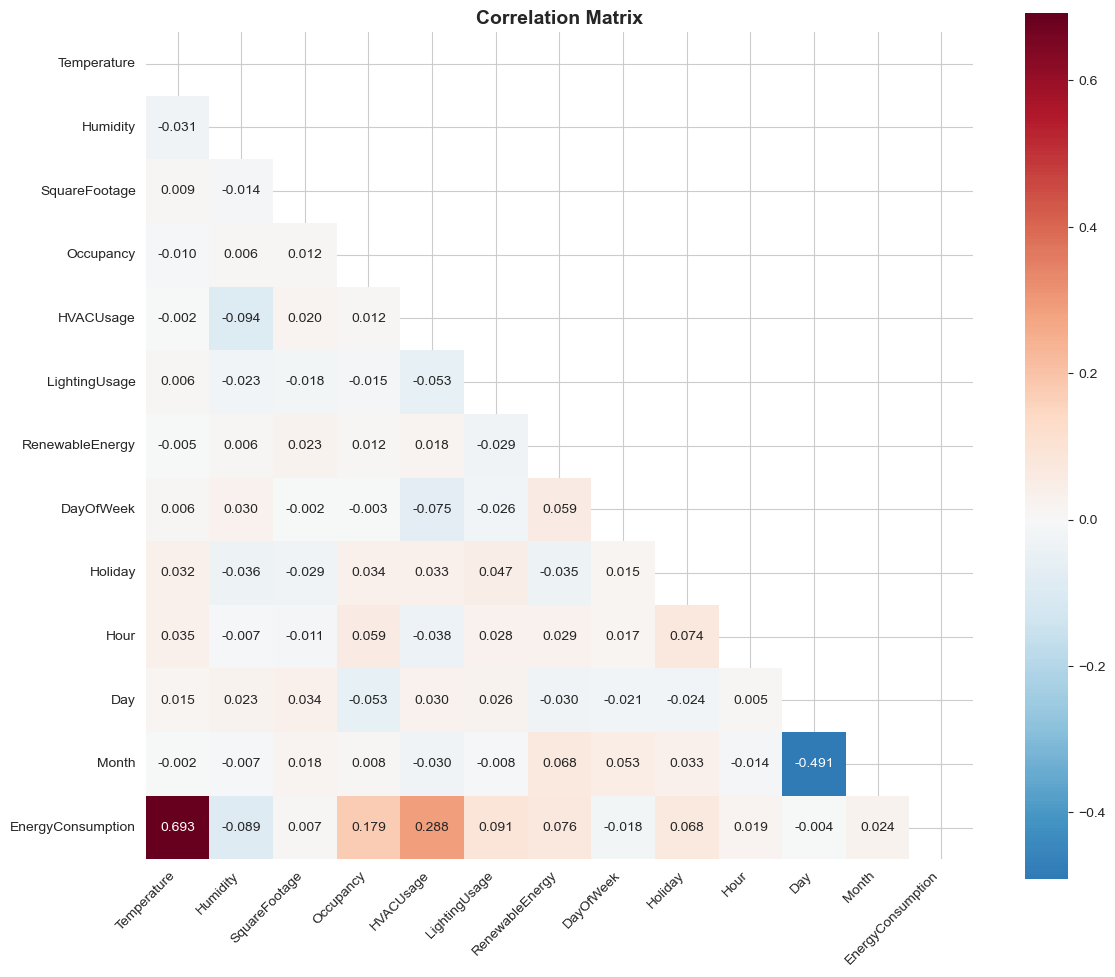

Correlations with EnergyConsumption:
----------------------------------------
Temperature     |   0.693
HVACUsage       |   0.288
Occupancy       |   0.179
LightingUsage   |   0.091
Humidity        |  -0.089
RenewableEnergy |   0.076
Holiday         |   0.068
Month           |   0.024
Hour            |   0.019
DayOfWeek       |  -0.018
SquareFootage   |   0.007
Day             |  -0.004


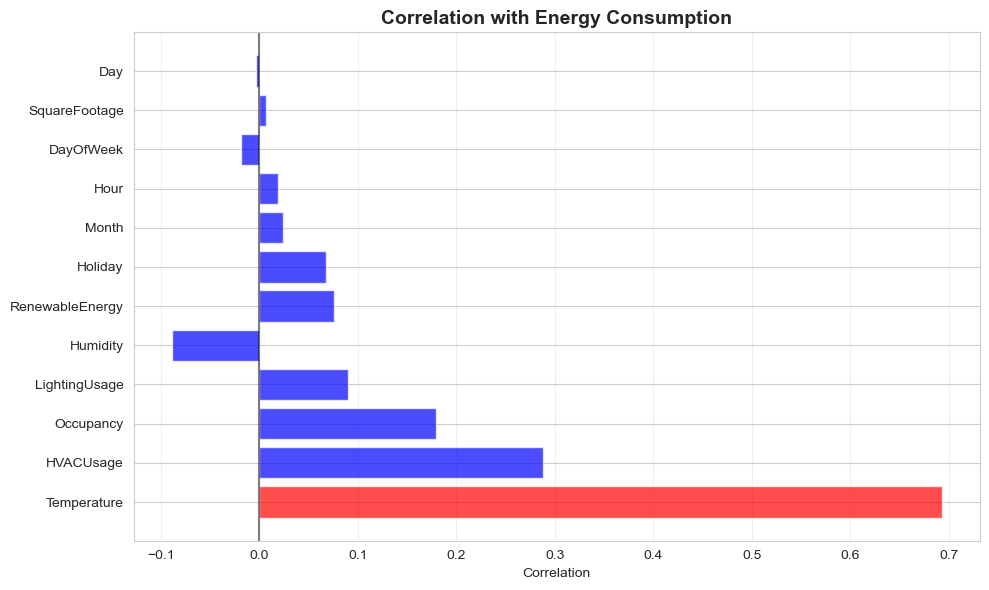

In [929]:
available_features = [col for col in numerical_features if col in data_clean.columns]
df_corr = data_clean[available_features]
correlation_matrix = df_corr.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, square=True, mask=mask, fmt='.3f')
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

if 'EnergyConsumption' in correlation_matrix.columns:
    energy_corr = correlation_matrix['EnergyConsumption'].drop('EnergyConsumption')
    energy_corr = energy_corr.sort_values(key=abs, ascending=False)
    
    print("Correlations with EnergyConsumption:")
    print("-" * 40)
    for var, corr in energy_corr.items():
        print(f"{var:<15} | {corr:7.3f}")
    
    plt.figure(figsize=(10, 6))
    colors = ['red' if abs(x) > 0.5 else 'blue' for x in energy_corr.values]
    plt.barh(range(len(energy_corr)), energy_corr.values, color=colors, alpha=0.7)
    plt.yticks(range(len(energy_corr)), energy_corr.index)
    plt.xlabel('Correlation')
    plt.title('Correlation with Energy Consumption', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## New features

The average energy consumption varies slightly across the days of the week, indicating energy usage is fairly consistent throughout the week.

When analysing average consumption throughout the day, greater variability can be seen. The hourly pattern suggests that there may be distinct periods of higher and lower energy use, possibly related to the buildings' usage cycles.

To study and simplify the effects of time of day, we can categorise consumption patterns into four groups, defined as:

- Morning: 6:00 a.m. to 12:00 p.m.
- Afternoon: 12:00 p.m. to 6:00 p.m.
- Evening: 6:00 p.m. to 9:00 p.m.
- Night: 9:00 p.m. to 6:00 a.m.

By generating this division, we reduce the number of features, decrease the complexity of the model, and at the same time retain meaningful information about energy consumption behaviour at different times of the day.


In [932]:
def get_time_period(hour):
    if 4 <= hour < 12:  
        return 'Morning'
    elif 12 <= hour < 16:  
        return 'Afternoon'
    elif 16 <= hour < 21:  
        return 'Evening'
    else:  
        return 'Night'

data_clean['TimePeriod'] = data_clean['Hour'].apply(get_time_period)
period_stats = data_clean.groupby('TimePeriod')['EnergyConsumption'].agg(['mean', 'std']).reset_index()
print("Average consumption per day period:")
print(period_stats)

Average consumption per day period:
  TimePeriod    mean        std  
0  Afternoon  76.865646  7.817703
1    Evening  77.241401  7.715353
2    Morning  76.649938  8.037517
3      Night  77.222616  8.266507


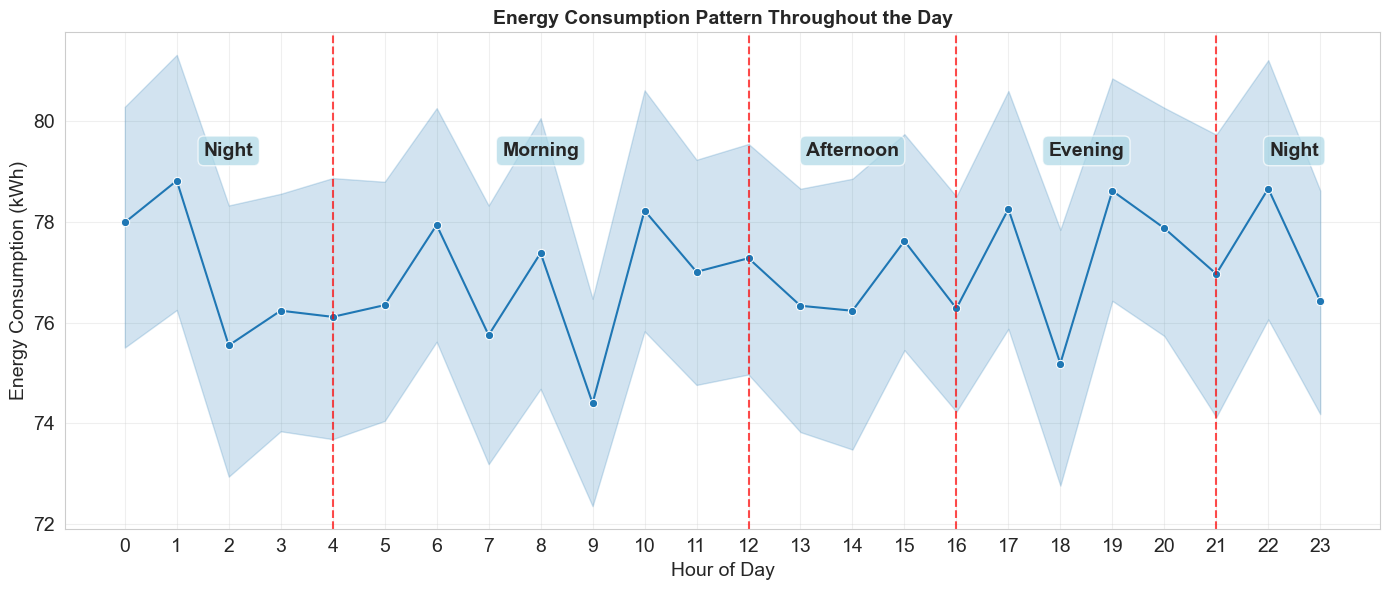

In [933]:
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

ax = sns.lineplot(data=data_clean, x='Hour', y='EnergyConsumption', estimator='mean', errorbar=('ci', 95), marker='o')

for hour in [4, 12, 16, 21]: ax.axvline(x=hour, color='red', linestyle='--', alpha=0.7)
period_positions = [(2, 'Night'), (8, 'Morning'), (14, 'Afternoon'), (18.5, 'Evening'), (22.5, 'Night')]
ylim = ax.get_ylim()
for pos, name in period_positions: ax.text(
        pos, ylim[1]*0.97, name, ha='center',
        fontweight='bold', fontsize=14,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))
ax.set_title('Energy Consumption Pattern Throughout the Day', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=14)
ax.set_ylabel('Energy Consumption (kWh)', fontsize=14)

ax.set_xticks(range(0, 24))
ax.set_xticklabels([str(h) for h in range(0,24)], fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [934]:
# df = df.drop('Hour', axis=1)
data_clean

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month,TimePeriod
0,25.139433,43.431581,1565.693999,5,1,0,2.774699,1,0,75.364373,0,1,1,Night
1,27.731651,54.225919,1411.064918,1,1,1,21.831384,6,0,83.401855,1,1,1,Night
2,28.704277,58.907658,1755.715009,2,0,0,6.764672,7,0,78.270888,2,1,1,Night
3,20.080469,50.371637,1452.316318,1,0,1,8.623447,3,0,56.519850,3,1,1,Night
4,23.097359,51.401421,1094.130359,9,1,0,3.071969,5,0,70.811732,4,1,1,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,28.619382,48.850160,1080.087000,5,0,0,21.194696,6,0,82.306692,11,11,2,Morning
996,23.836647,47.256435,1705.235156,4,0,1,25.748176,2,1,66.577320,12,11,2,Afternoon
997,23.005340,48.720501,1320.285281,6,0,1,0.297079,5,1,72.753471,13,11,2,Afternoon
998,25.138365,31.306459,1309.079719,3,1,0,20.425163,4,1,76.950389,14,11,2,Afternoon


Now, it is necessary to analyze whether the holidays add significant variations to the energy consumption analysis.

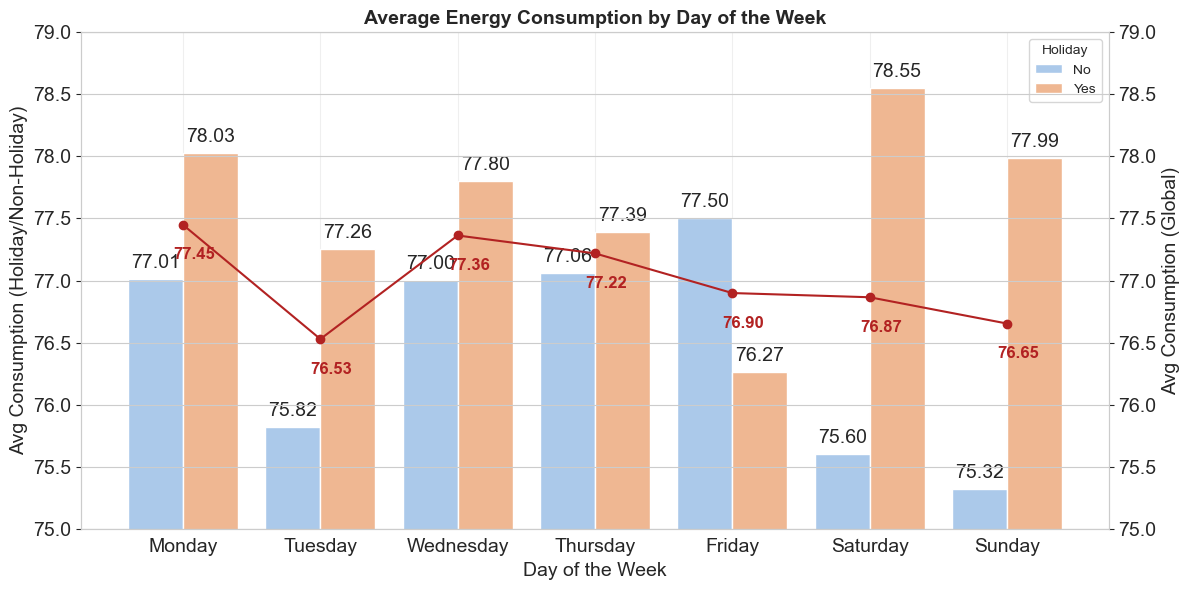

In [936]:
dow_map = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
           5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

data_clean['DayOfWeekLabel'] = data_clean['DayOfWeek'].map(dow_map)
data_clean['HolidayLabel'] = data_clean['Holiday'].map({0: 'No', 1: 'Yes'})

week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

holiday_avg = data_clean.groupby(['DayOfWeekLabel', 'HolidayLabel'])['EnergyConsumption'].mean().reset_index()
holiday_avg['DayOfWeekLabel'] = pd.Categorical(holiday_avg['DayOfWeekLabel'], categories=week_order, ordered=True)
holiday_avg = holiday_avg.sort_values('DayOfWeekLabel')

daily_avg_consumption = data_clean.groupby('DayOfWeekLabel')['EnergyConsumption'].mean().reset_index()
daily_avg_consumption['DayOfWeekLabel'] = pd.Categorical(daily_avg_consumption['DayOfWeekLabel'], categories=week_order, ordered=True)
daily_avg_consumption = daily_avg_consumption.sort_values('DayOfWeekLabel')

fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set_style("whitegrid")

# Holiday vs Non-Holiday
sns.barplot(data=holiday_avg, x='DayOfWeekLabel', y='EnergyConsumption', hue='HolidayLabel', palette='pastel', ax=ax1)
for container in ax1.containers:
    ax1.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues], padding=5, fontsize=14)

ax1.set_xlabel('Day of the Week', fontsize=14)
ax1.set_ylabel('Avg Consumption (Holiday/Non-Holiday)', fontsize=14)
ax1.set_title('Average Energy Consumption by Day of the Week', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.legend(title='Holiday')
ax1.set_ylim(75, 79)

ax2 = ax1.twinx()
ax2.plot(daily_avg_consumption['DayOfWeekLabel'], daily_avg_consumption['EnergyConsumption'],
    marker='o', color='firebrick', label='Global Mean')
for x, y in zip(range(7), daily_avg_consumption['EnergyConsumption']):
    ax2.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(8,-27), ha='center', 
    va='bottom', fontsize=12, fontweight='bold', color='firebrick')
    
ax2.set_ylabel('Avg Consumption (Global)', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_ylim(75, 79)

plt.tight_layout()
plt.show()

The graph shows average energy consumption by day of the week, which remains relatively stable throughout the week. Energy consumption patterns do not vary significantly by day of the week.

The overall average remains between the values ​​of the holiday and non-holiday bars, suggesting that holidays raise the weekly average. On the other hand, consumption varies throughout the week, with peaks on Tuesdays and Saturdays, where overall values ​​have a similar trend to non-holidays, and these days have a marked difference between holidays and working days. This leads us to maintain both characteristics.

In [938]:
# Create a new column for Weekday/Weekend
data_clean['WeekendLabel'] = data_clean['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 6 else 'Weekday')
weekend_stats = data_clean.groupby('WeekendLabel')['EnergyConsumption'].agg(['mean', 'std', 'median', 'min', 'max']).reset_index()
print(weekend_stats)

  WeekendLabel    mean        std     median       min        max   
0    Weekday    77.066713  8.049664  76.901018  56.158206  96.827015
1    Weekend    76.754284  7.873976  77.075963  56.038163  94.178518


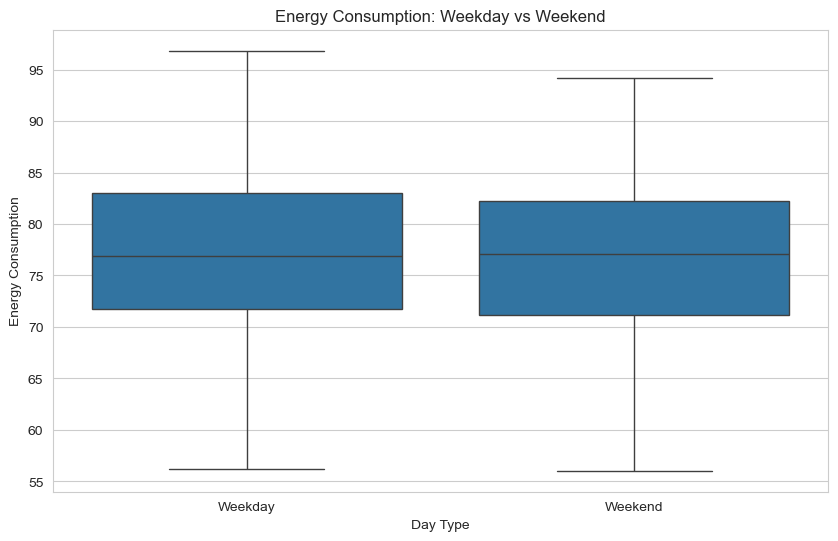

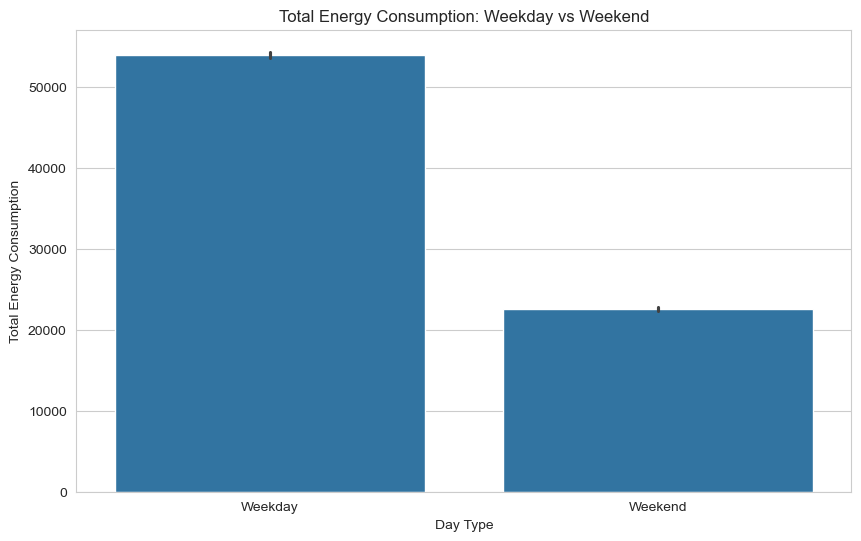

In [939]:
# Boxplot Consumo por Weekday vs Weekend
plt.figure(figsize=(10, 6))
sns.boxplot(x='WeekendLabel', y='EnergyConsumption', data=data_clean)
plt.title('Energy Consumption: Weekday vs Weekend')
plt.xlabel('Day Type')
plt.ylabel('Energy Consumption')
plt.show()

# Barplot de consumo total (sum) por Weekday vs Weekend
plt.figure(figsize=(10, 6))
sns.barplot(x='WeekendLabel', y='EnergyConsumption', data=data_clean, estimator=sum)
plt.title('Total Energy Consumption: Weekday vs Weekend')
plt.xlabel('Day Type')
plt.ylabel('Total Energy Consumption')
plt.show()

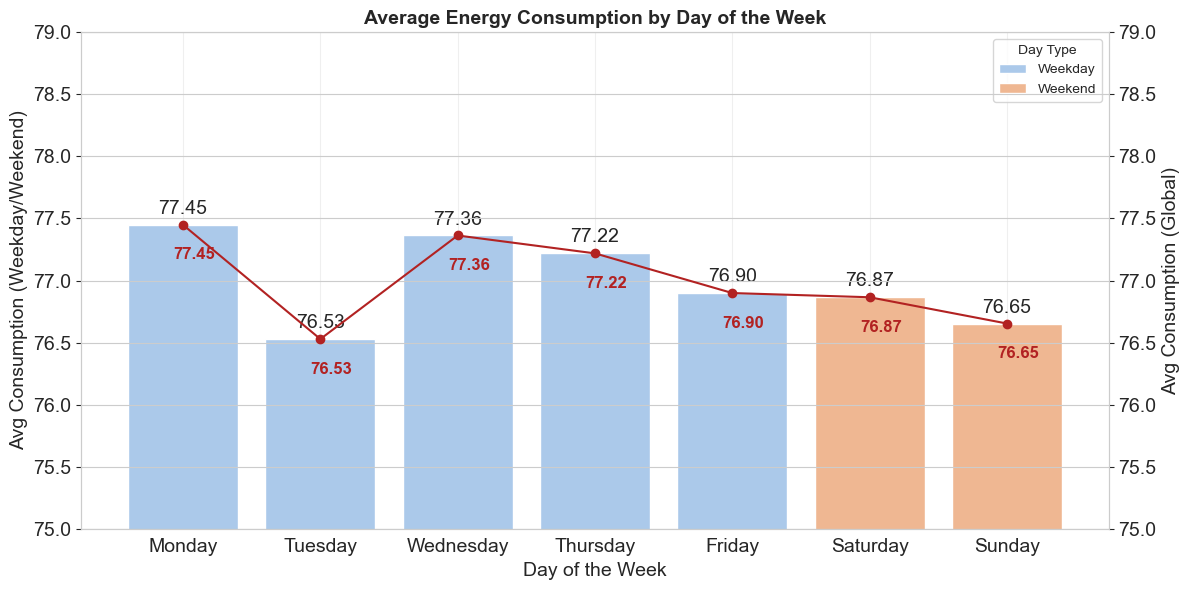

In [940]:
# Agrupado por día y por Weekday/Weekend
weekend_avg = data_clean.groupby(['DayOfWeekLabel', 'WeekendLabel'])['EnergyConsumption'].mean().reset_index()
weekend_avg['DayOfWeekLabel'] = pd.Categorical(weekend_avg['DayOfWeekLabel'], categories=week_order, ordered=True)
weekend_avg = weekend_avg.sort_values('DayOfWeekLabel')

# Promedio global por día (sin distinguir Weekday/Weekend)
daily_avg_consumption = data_clean.groupby('DayOfWeekLabel')['EnergyConsumption'].mean().reset_index()
daily_avg_consumption['DayOfWeekLabel'] = pd.Categorical(daily_avg_consumption['DayOfWeekLabel'], categories=week_order, ordered=True)
daily_avg_consumption = daily_avg_consumption.sort_values('DayOfWeekLabel')


fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set_style("whitegrid")

# Weekday vs Weekend
sns.barplot(data=weekend_avg, x='DayOfWeekLabel', y='EnergyConsumption', hue='WeekendLabel', palette='pastel', ax=ax1)
for container in ax1.containers:
    ax1.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues], padding=5, fontsize=14)

ax1.set_xlabel('Day of the Week', fontsize=14)
ax1.set_ylabel('Avg Consumption (Weekday/Weekend)', fontsize=14)
ax1.set_title('Average Energy Consumption by Day of the Week', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.legend(title='Day Type')
ax1.set_ylim(75, 79)

# Línea del promedio global
ax2 = ax1.twinx()
ax2.plot(daily_avg_consumption['DayOfWeekLabel'], daily_avg_consumption['EnergyConsumption'],
    marker='o', color='firebrick', label='Global Mean')
for x, y in zip(range(7), daily_avg_consumption['EnergyConsumption']):
    ax2.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(8,-27), ha='center', 
    va='bottom', fontsize=12, fontweight='bold', color='firebrick')

ax2.set_ylabel('Avg Consumption (Global)', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_ylim(75, 79)

plt.tight_layout()
plt.show()

In [942]:
data_clean

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month,TimePeriod,DayOfWeekLabel,HolidayLabel,WeekendLabel
0,25.139433,43.431581,1565.693999,5,1,0,2.774699,1,0,75.364373,0,1,1,Night,Monday,No,Weekday
1,27.731651,54.225919,1411.064918,1,1,1,21.831384,6,0,83.401855,1,1,1,Night,Saturday,No,Weekend
2,28.704277,58.907658,1755.715009,2,0,0,6.764672,7,0,78.270888,2,1,1,Night,Sunday,No,Weekend
3,20.080469,50.371637,1452.316318,1,0,1,8.623447,3,0,56.519850,3,1,1,Night,Wednesday,No,Weekday
4,23.097359,51.401421,1094.130359,9,1,0,3.071969,5,0,70.811732,4,1,1,Morning,Friday,No,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,28.619382,48.850160,1080.087000,5,0,0,21.194696,6,0,82.306692,11,11,2,Morning,Saturday,No,Weekend
996,23.836647,47.256435,1705.235156,4,0,1,25.748176,2,1,66.577320,12,11,2,Afternoon,Tuesday,Yes,Weekday
997,23.005340,48.720501,1320.285281,6,0,1,0.297079,5,1,72.753471,13,11,2,Afternoon,Friday,Yes,Weekday
998,25.138365,31.306459,1309.079719,3,1,0,20.425163,4,1,76.950389,14,11,2,Afternoon,Thursday,Yes,Weekday


In [1067]:
data_clean['WeekendLabel'] = label_encoder.fit_transform(data_clean['WeekendLabel'])
data_clean['TimePeriodLabel'] = label_encoder.fit_transform(data_clean['TimePeriod'])
# Night: 3/ Morning: 2/ Afternoon: 0 /Evening: 1

data_clean

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month,TimePeriod,DayOfWeekLabel,HolidayLabel,WeekendLabel,TimePeriodLabel
0,25.139433,43.431581,1565.693999,5,1,0,2.774699,1,0,75.364373,0,1,1,Night,Monday,No,0,3
1,27.731651,54.225919,1411.064918,1,1,1,21.831384,6,0,83.401855,1,1,1,Night,Saturday,No,1,3
2,28.704277,58.907658,1755.715009,2,0,0,6.764672,7,0,78.270888,2,1,1,Night,Sunday,No,1,3
3,20.080469,50.371637,1452.316318,1,0,1,8.623447,3,0,56.519850,3,1,1,Night,Wednesday,No,0,3
4,23.097359,51.401421,1094.130359,9,1,0,3.071969,5,0,70.811732,4,1,1,Morning,Friday,No,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,28.619382,48.850160,1080.087000,5,0,0,21.194696,6,0,82.306692,11,11,2,Morning,Saturday,No,1,2
996,23.836647,47.256435,1705.235156,4,0,1,25.748176,2,1,66.577320,12,11,2,Afternoon,Tuesday,Yes,0,0
997,23.005340,48.720501,1320.285281,6,0,1,0.297079,5,1,72.753471,13,11,2,Afternoon,Friday,Yes,0,0
998,25.138365,31.306459,1309.079719,3,1,0,20.425163,4,1,76.950389,14,11,2,Afternoon,Thursday,Yes,0,0


# Modelling

## Preprocessing

In [1069]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        994 non-null    float64
 1   Humidity           994 non-null    float64
 2   SquareFootage      994 non-null    float64
 3   Occupancy          994 non-null    int64  
 4   HVACUsage          994 non-null    int32  
 5   LightingUsage      994 non-null    int32  
 6   RenewableEnergy    994 non-null    float64
 7   DayOfWeek          994 non-null    int8   
 8   Holiday            994 non-null    int32  
 9   EnergyConsumption  994 non-null    float64
 10  Hour               994 non-null    int32  
 11  Day                994 non-null    int32  
 12  Month              994 non-null    int32  
 13  TimePeriod         994 non-null    object 
 14  DayOfWeekLabel     994 non-null    object 
 15  HolidayLabel       994 non-null    object 
 16  WeekendLabel       994 non-null

In [1071]:
data_clean.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month,TimePeriod,DayOfWeekLabel,HolidayLabel,WeekendLabel,TimePeriodLabel
0,25.139433,43.431581,1565.693999,5,1,0,2.774699,1,0,75.364373,0,1,1,Night,Monday,No,0,3
1,27.731651,54.225919,1411.064918,1,1,1,21.831384,6,0,83.401855,1,1,1,Night,Saturday,No,1,3
2,28.704277,58.907658,1755.715009,2,0,0,6.764672,7,0,78.270888,2,1,1,Night,Sunday,No,1,3
3,20.080469,50.371637,1452.316318,1,0,1,8.623447,3,0,56.519850,3,1,1,Night,Wednesday,No,0,3
4,23.097359,51.401421,1094.130359,9,1,0,3.071969,5,0,70.811732,4,1,1,Morning,Friday,No,0,2


In [1155]:
features = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy','HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday','Hour','Day', 'Month','WeekendLabel', 'TimePeriodLabel']          

### Separate features and target variable and split (Train/Test)

In [1158]:
X = data_clean[features]
y = data_clean['EnergyConsumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Dataset shape:", X.shape)
print("Target shape:", y.shape)

Dataset shape: (994, 13)
Target shape: (994,)


## Models


=== Model Performance ===
Model Comparison:
--------------------------------------------------
Linear Regression  | R²: 0.6180 | RMSE: 5.04
Ridge              | R²: 0.6179 | RMSE: 5.04
Random Forest      | R²: 0.5773 | RMSE: 5.30
XGBoost            | R²: 0.6061 | RMSE: 5.12

Best model: Linear Regression


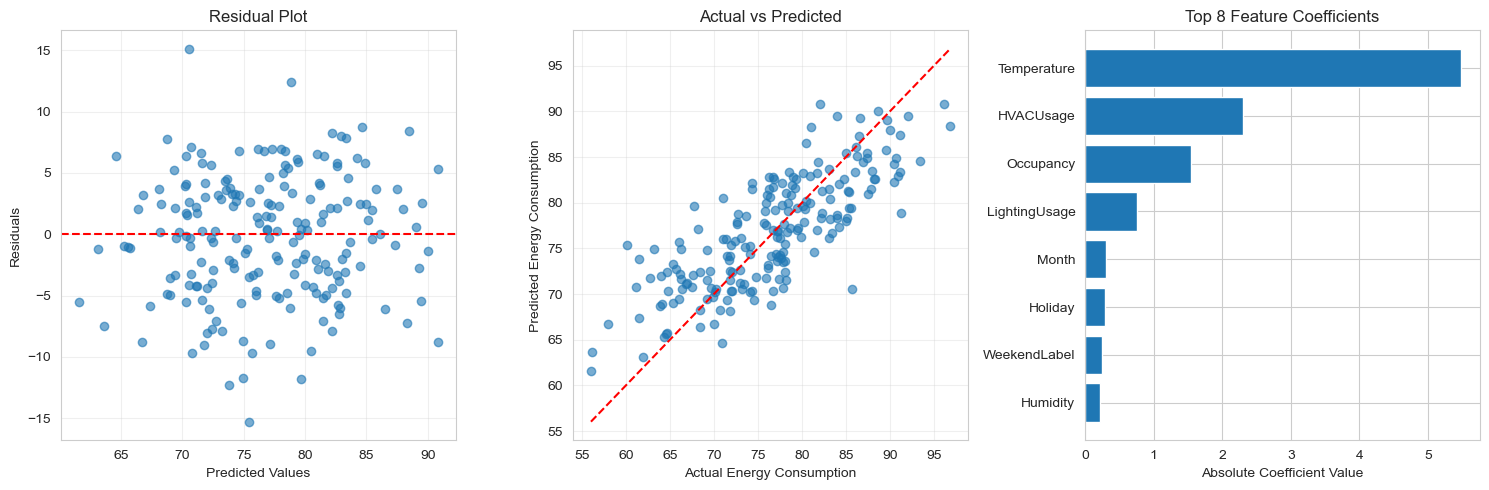

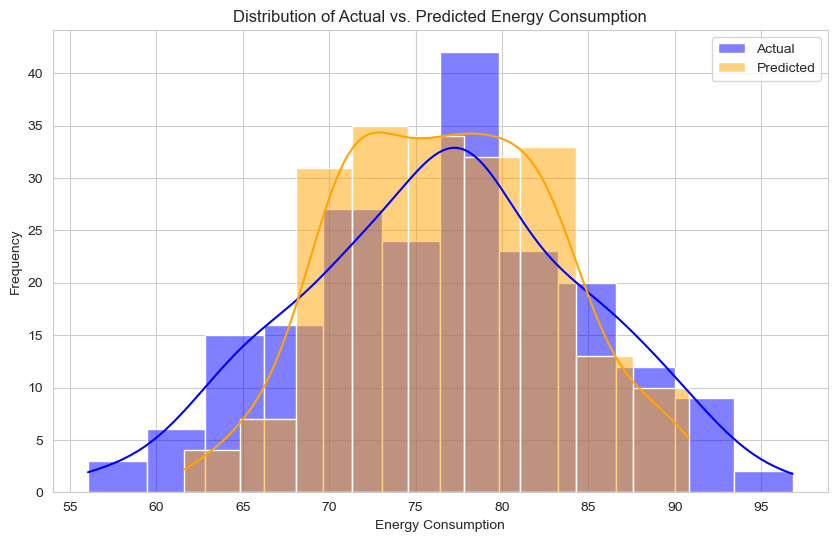

Trained model saved to: Linear_Regression_model.pkl
Scaler saved to: scaler.pkl


In [1161]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
}

results = {}
predictions = {}

print(f"\n=== Model Performance ===")
print("Model Comparison:")
print("-" * 50)

for name, model in models.items():
    if name in ['Random Forest', 'XGBoost']:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {'R2': r2, 'RMSE': rmse, 'model': model}
    predictions[name] = y_pred
    print(f"{name:<18} | R²: {r2:.4f} | RMSE: {rmse:.2f}")

# Find the best model by R2
best_model_name = max(results.keys(), key=lambda x: results[x]['R2'])
best_model = results[best_model_name]['model']
y_pred_best = predictions[best_model_name]
print(f"\nBest model: {best_model_name}")

# Compute residuals for the best model
residuals = y_test - y_pred_best

# Feature importance or coefficients
if best_model_name in ['Linear Regression', 'Ridge']:
    feature_importance = best_model.coef_
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"X{i}" for i in range(X_train.shape[1])]
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': feature_importance,
        'abs_coefficient': np.abs(feature_importance)
    }).sort_values('abs_coefficient', ascending=False)
elif best_model_name == 'Random Forest':
    feature_importance = best_model.feature_importances_
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"X{i}" for i in range(X_train.shape[1])]
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance,
        'abs_importance': np.abs(feature_importance)
    }).sort_values('abs_importance', ascending=False)
elif best_model_name == 'XGBoost':
    feature_importance = best_model.feature_importances_
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"X{i}" for i in range(X_train.shape[1])]
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance,
        'abs_importance': np.abs(feature_importance)
    }).sort_values('abs_importance', ascending=False)
    
# === Visualizations ===
plt.figure(figsize=(15, 5))

# 1. Residual plot
plt.subplot(1, 3, 1)
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True, alpha=0.3)

# 2. Actual vs Predicted
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.title("Actual vs Predicted")
plt.xlabel("Actual Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.grid(True, alpha=0.3)

# 3. Feature importance plot
plt.subplot(1, 3, 3)
if best_model_name in ['Linear Regression', 'Ridge']:
    top_features = importance_df.head(8)
    plt.barh(range(len(top_features)), top_features['abs_coefficient'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.title("Top 8 Feature Coefficients")
    plt.xlabel("Absolute Coefficient Value")
    plt.gca().invert_yaxis()
elif best_model_name in ['Random Forest', 'XGBoost']:
    top_features = importance_df.head(8)
    plt.barh(range(len(top_features)), top_features['abs_importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.title("Top 8 Feature Importances")
    plt.xlabel("Importance Value")
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
# === Distribution plot: Actual vs Predicted (for best model) ===
plt.figure(figsize=(10, 6))
sns.histplot(y_test, label='Actual', kde=True, color='blue', alpha=0.5)
sns.histplot(y_pred_best, label='Predicted', kde=True, color='orange', alpha=0.5)
plt.xlabel('Energy Consumption')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs. Predicted Energy Consumption')
plt.legend()
plt.show()

# Save the best model
model_path = f"{best_model_name.replace(' ', '_')}_model.pkl"
joblib.dump(best_model, model_path)
print(f"Trained model saved to: {model_path}")
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved to: scaler.pkl")

The best model predicts energy consumption and the RMSE is 5, meaning that, on average, the model predictions are within ±5 units (e.g., kWh) of the actual values.

In [1165]:
features = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy','HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday','Hour','Day', 'Month','WeekendLabel', 'TimePeriodLabel']      
# --- Mappings auxiliares ---
def get_time_period(hour):
    if 4 <= hour < 12:
        return 2  # Morning
    elif 12 <= hour < 16:
        return 0  # Afternoon
    elif 16 <= hour < 21:
        return 1  # Evening
    else:
        return 3  # Night

def get_weekend_label(dayofweek):
    return 1 if dayofweek >= 6 else 0  # 1=Weekend, 0=Weekday

# --- Ejemplo de valores de entrada ---
input_example = {
    'Temperature': 25.0,
    'Humidity': 45.0,
    'SquareFootage': 1800,
    'Occupancy': 8,
    'HVACUsage': 1,       # 1 = On, 0 = Off
    'LightingUsage': 1,   # 1 = On, 0 = Off
    'DayOfWeek': 6,       # 6 = Saturday
    'Holiday': 0,         # 1 = Yes, 0 = No
    'Hour': 14,
    'Day': 20,
    'Month': 7
}
# Calcula weekend y timeperiod
input_example['WeekendLabel'] = get_weekend_label(input_example['DayOfWeek'])
input_example['TimePeriodLabel'] = get_time_period(input_example['Hour'])

# --- Ordena y convierte a DataFrame ---
input_df = pd.DataFrame([input_example])[features]

# --- Carga modelo y scaler ---
model = joblib.load("Linear_Regression_model.pkl")
scaler = joblib.load("scaler.pkl")  # Usa el scaler original que guardaste al entrenar

# --- Escala los datos ---
input_scaled = scaler.transform(input_df)

# --- Predice ---
predicted_energy = model.predict(input_scaled)[0]
print(f"Predicted Energy Consumption: {predicted_energy:.2f} kWh")

Predicted Energy Consumption: 85.22 kWh


In [392]:
df2 = pd.DataFrame({
    'y_test': y_test.values,    # use .values to avoid index issues
    'y_pred': y_pred_best
})

# If you want to keep the original indices:
# df2 = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Or, reset index if you want a clean 0-based index:
df2 = df2.reset_index(drop=True)

print(df2)

      y_test     y_pred  
0    92.058469  89.822586
1    84.759113  82.663340
2    82.223456  78.295264
3    81.890115  84.623397
4    88.628403  89.902228
..         ...        ...
194  91.119981  87.540288
195  61.896415  62.993973
196  76.106178  73.389292
197  78.138963  75.245434
198  78.924743  82.047588

[199 rows x 2 columns]
